# Sentiment Analysis for Brand Perception (Twitter)

In [26]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [28]:
# create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
# load the data
df = pd.read_csv('twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [29]:
# basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


The columns are:      
``ID``: Unique identifier for each entry  
``Entity``: Entity or brand mentioned in social media content  
``Sentiment``: Sentiment labels (e.g., Positive, Negative, Neutral)  
``Content``: Text content of social media posts

In [30]:
# Check Data Dimensions
df.shape

(74682, 4)

The dataset consists of 74682 rows and 4 columns.

In [31]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

## Data Preparation

In [32]:
# check for missing values
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

##### Dealing with the missing values

In [33]:
# dropping the rows with content missing values
df.dropna(subset = ['Content'],inplace=True)

In [34]:
# Count the total number of duplicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2340


Drop the duplicated rows

In [35]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

replace irrelevant to neutral

In [36]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

## Exploratory Data Analysis

#### Sentiment distribution

In [37]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

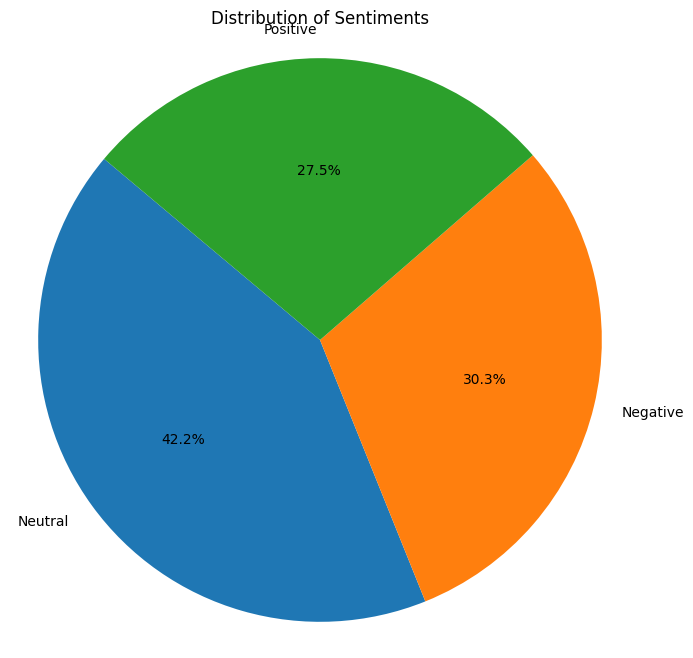

In [38]:
# Calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Show the pie chart 42.2
plt.show()

#### Sentiment Distribution Analysis

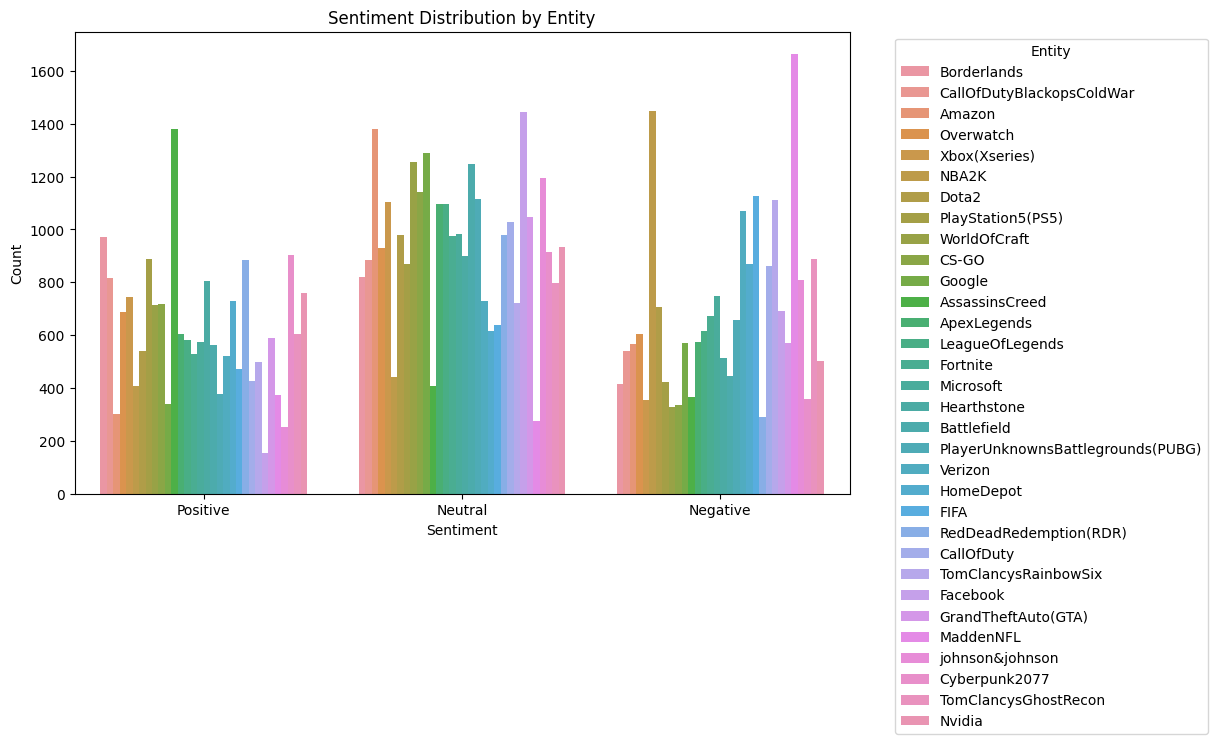

In [39]:
# Example for sentiment distribution by entity
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title("Sentiment Distribution by Entity")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Text Analysis with NLP Preprocessing

### NLP Preprocessing

**Steps**:
* Removed special characters, numbers, and links from the text.
* Converted text to lowercase.
* Tokenized the text into words.
* Removed stopwords  
* lemmatization

In [40]:
# lets Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to C:\Users\Oumaima
[nltk_data]     Toufali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Oumaima
[nltk_data]     Toufali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Oumaima
[nltk_data]     Toufali\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Sentiment Analysis

In [41]:
# loading vader to perform sentiment analysis
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer without specifying the lexicon file
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to the 'Cleaned_Content' column
df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

# Categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization
df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)


[nltk_data] Downloading package vader_lexicon to C:\Users\Oumaima
[nltk_data]     Toufali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Distribution of predicted sentiments

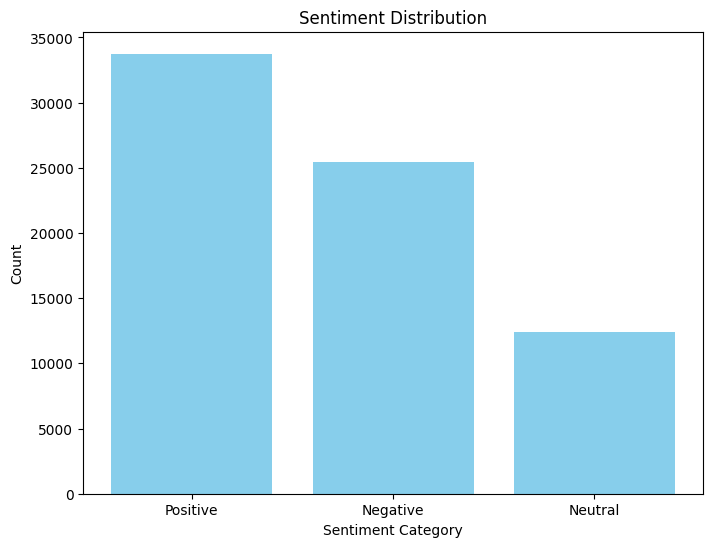

In [42]:
# lets Calculate the distribution of predicted sentiments
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

# Create a bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# Show the bar chart
plt.show()

## Model training and evaluation

### Data Splitting

In [44]:
# Assign the variables
X = df['Cleaned_Content']  # Features
y = df['Sentiment_Predicted']  # Target
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Feature Extraction (Vectorization)

In [45]:
# converting the text data to numerical featurees

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


### Model Training

In [46]:

# Initialize the model
model = LogisticRegression(max_iter=1000, solver='saga')

# Train the model
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, solver='saga')

### Model Evaluation

In [47]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9067122523025398
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5066
     Neutral       0.89      0.85      0.87      2471
    Positive       0.92      0.93      0.93      6795

    accuracy                           0.91     14332
   macro avg       0.90      0.89      0.90     14332
weighted avg       0.91      0.91      0.91     14332

